In [1]:
from __future__ import print_function
import sys,os,datetime
import cv2 as cv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import fbeta_score
import sklearn.metrics as skm
import csv

In [2]:
print('openCV',cv.__version__)
print('numpy',np.__version__)

openCV 3.2.0
numpy 1.13.3


In [3]:
dirLoadP = '../Data/crack_probability'
dirLoadL = '../Data/ground_truth_training'

In [52]:
tData = np.load(os.path.join(dirLoadP,'crack_probability.npy'))
lData = np.load(os.path.join(dirLoadL,'ground_truth_training.npy'))

In [53]:
tData.shape, lData.shape

((333, 480, 640), (333, 480, 640))

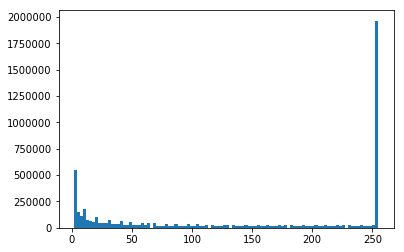

In [6]:
plt.hist(tData[tData>0].ravel(),bins=100); plt.show()

60.06006006006007

In [140]:
from sklearn.cluster import KMeans
def kkmeans (tData, stepZ=20, minCrack=50, countC=100, jobs=6, shift=1) :
    result = []
    for ii in range(0,tData.shape[0],stepZ) :
        iif = ii-shift if ii-shift>=0 else ii
        print(datetime.datetime.now(),iif,min(tData.shape[0],ii+stepZ),tData.shape[0])
        lData = np.where(tData[iif:ii+stepZ]>0)
        vData = tData[lData[0],lData[1],lData[2]];
        xData = np.array(lData+(vData,)).T
        kmeans = KMeans(n_clusters=countC, random_state=0, n_jobs=jobs).fit(xData)
        result.append((iif,min(tData.shape[0],ii+stepZ),kmeans))
    print(datetime.datetime.now(),'The End')
    return(result)

In [99]:
minCrack=50
countCrack=50
kk = kkmeans(tData, minCrack=minCrack, countC=countCrack)

2017-12-13 18:53:41.277590 0 20 333
2017-12-13 18:55:00.243077 19 40 333
2017-12-13 18:56:08.251553 39 60 333
2017-12-13 18:56:58.110579 59 80 333
2017-12-13 18:57:40.554008 79 100 333
2017-12-13 18:58:28.819470 99 120 333
2017-12-13 18:59:16.203179 119 140 333
2017-12-13 19:00:11.995262 139 160 333
2017-12-13 19:00:57.760951 159 180 333
2017-12-13 19:01:49.643884 179 200 333
2017-12-13 19:02:37.120128 199 220 333
2017-12-13 19:03:29.283047 219 240 333
2017-12-13 19:04:08.325995 239 260 333
2017-12-13 19:04:52.782609 259 280 333
2017-12-13 19:05:30.307276 279 300 333
2017-12-13 19:06:00.330909 299 320 333
2017-12-13 19:06:32.837288 319 340 333
2017-12-13 19:06:49.610393 The End


In [101]:
kk[1]

(19, 40, KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
     n_clusters=100, n_init=10, n_jobs=6, precompute_distances='auto',
     random_state=0, tol=0.0001, verbose=0))

In [102]:
kk[-1][2].labels_,kk[-1][2].cluster_centers_, 
kk[1][2].labels_.shape, len(np.where(tData[19:40]>0)[0]),kk[-1][2].labels_.shape, len(np.where(tData[319:340]>0)[0])

((371211,), 371211, (149524,), 149524)

In [210]:
xx=set([]); xx.add(1); xx.add(128);xx.add(256); print(xx)

set([128, 1, 256])


In [247]:
def unionSlices (kkk) :
    tData0        = np.zeros(tData.shape)
    (l0, ll), n1  = kkk[0][:2], tData0.max()+1;
    lb0           = kkk[0][2]+n1;  print(l0,ll,n1)

    for ii in range(3) : #len(kkk)-1) :

        yData = np.where(tData[l0:ll]>0)
        assert(len(yData[0])==len(lb0))
        tData0[yData[0],yData[1],yData[2]] = lb0

        temp0  = np.int32(tData0[ll-1])

        (l01, ll1), n1  = kkk[ii+1][:2], tData0.max()+1;
        tempX  = np.zeros((((ll1-l01),)+temp0.shape))

        lb1    = kkk[ii+1][2]+n1
        yData  = np.where(tData[l01:ll1]>0)
        assert(len(yData[0])==len(lb1))
        
        yData  = np.array([yData[0],yData[1],yData[2],lb1],dtype=np.int32); print(yData.shape)

        tempX[yData[0],yData[1],yData[2]] = lb1
        temp1  = np.int32(tempX[0])

        # union 0&1 levels

        print(datetime.datetime.now(),ii,(l0,ll),(l01,ll1),max(temp0.max(),temp1.max())) #,yData[0],yData[1],yData[2])
        
        temp0X = temp0.copy(); temp0X[temp0<>1]=0; 
        print('1', temp0X.sum(),temp0X.size, temp0.shape)
        temp0X[temp0==1]=255; 
        plt.figure(figsize=(15,6))
        plt.subplot(121); plt.imshow(temp0,'gray'); 
        plt.subplot(122);plt.imshow(temp1);
        plt.show()
        
        # build refs between 0&1
        
        for iii in range((int(max(temp0.max(),temp1.max())+1))) : aTemp[iii]=set([iii])
            
        for iii in range(temp0.shape[0]) : 
            for jjj in range(temp0.shape[1]) : 
                a0, a1 = temp0[iii,jjj].copy(), temp1[iii,jjj].copy()
                if  a0>0 and a1>0 and a0<>a1 :
                    #if a0==1 : print(iii,jjj,a0,a1,aTemp[a0])
                    aTemp[a0].add(a1); aTemp[a1].add(a0);
                
        #print('1 union',aTemp)

        # build sets from refs between 0&1 on each element
        OK = True;
        while OK :
            OK = False;
            for jj in range(len(aTemp)) :
                if len(aTemp)>0 :
                    for kk in aTemp[jj] :
                        old = aTemp[kk]
                        new = aTemp[kk].union(aTemp[jj])
                        if len(old&new)<>len(old) : OK, aTemp[kk] = True, new

        #print('2 union',aTemp)

        # calculate new numbers
        bTemp = np.zeros(len(aTemp),dtype=np.int32)
        for jj in range(len(aTemp)) :
            if aTemp[jj]<>set([]) : bTemp[jj] = min([xx for xx in aTemp[jj]])
                
        print('renumbering',bTemp.shape,bTemp[:100],bTemp[100:])

        # re-numbering
        for jj in range(len(bTemp)) :
            if bTemp[jj]>0 :
                tData0[tData0==jj] = bTemp[jj]
                lb1[lb1==jj]       = bTemp[jj] 

        # go forward
        l0, ll, lb0 = l01, ll1, lb1
        
    return(tData0)

0 20 1.0
(4, 371211)
2017-12-13 21:06:56.557526 0 (0, 20) (19, 40) 200
1 273 307200 (480, 640)


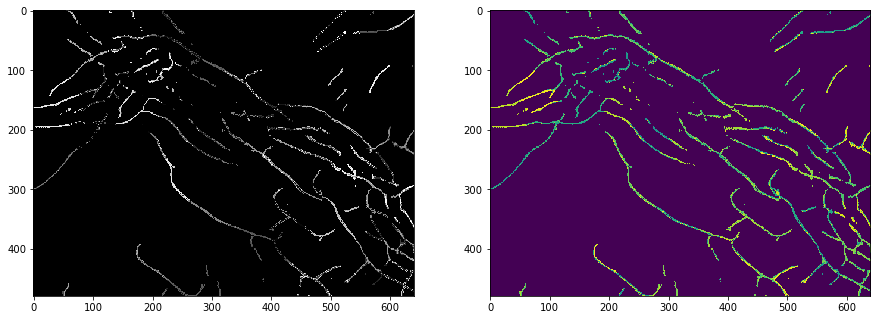

renumbering (401,) [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49
 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74
 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99] [100  16   8   3  25   1  11  17  15  23  30   8   8   6   2   9  14  15
   7   2   6  16   5   7   3   1  10  10   1  30   9  12  12  10  17  18
  11  23   3   1  14   8   6  12  17   4   9  28  11   2   4   7   8  49
   7   7  10  26   9   6  15   6   2   1   3  29  30  15  17  11   3  14
  10   4  16  17  28   3   8   1  18  76   7  15   8  22   2   4  12   6
   5  20   6   5   3  10  18   1  15   8   9 201 202 203 204 205 206 207
 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225
 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243
 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261
 262 263 264 265 26

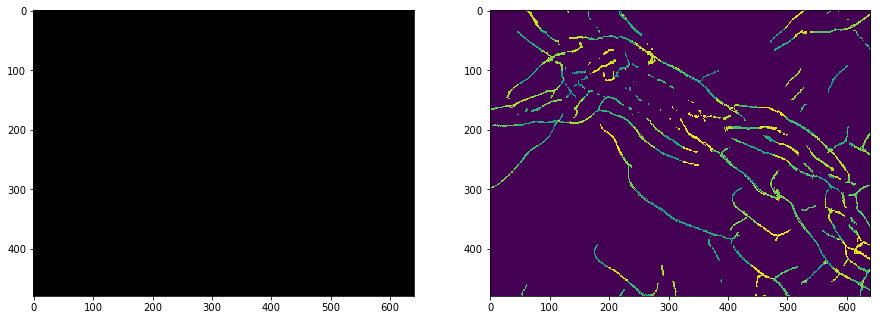

renumbering (401,) [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49
 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74
 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99] [100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117
 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135
 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153
 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171
 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189
 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207
 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225
 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243
 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261
 262 263 264 265 26

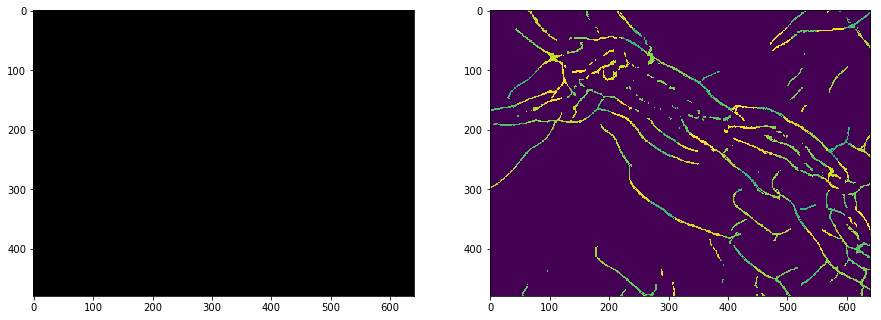

renumbering (401,) [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49
 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74
 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99] [100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117
 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135
 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153
 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171
 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189
 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207
 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225
 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243
 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261
 262 263 264 265 26

In [248]:
kkk = [(k0,k1,k2.labels_) for (k0,k1,k2) in kk]

tDataX = unionSlices(kkk)

In [180]:
xData.shape, 480*640

((21, 480, 640), 307200)

In [ ]:
tData0        = np.zeros(tData.shape)
(l0, ll), n1  = kkk[0][:2], tData0.max()+1;
lb0           = kkk[0][2]+n1;  print(l0,ll,n1)

yData = np.where(tData[l0:ll]>0)
tData0[yData[0],yData[1],yData[2]] = lb0

temp0  = np.int32(tData0[ll-1])



255 1.0 200.0


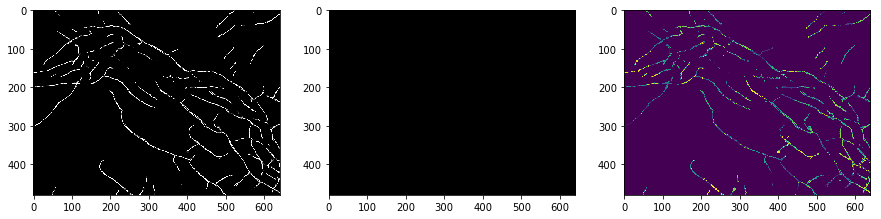

In [152]:
slice = 0
print(tData[slice].max(),tDataX[slice].max(),tData0[slice].max())
plt.figure(figsize=(15,6))
plt.subplot(131); plt.imshow(tData[slice],'gray'); 
plt.subplot(132); plt.imshow(tDataX[slice],'gray'); 
plt.subplot(133); plt.imshow(tData0[slice]); 
plt.show() 

In [107]:
kkk

[(0, 20, array([60, 60, 83, ..., 82, 12, 12], dtype=int32)),
 (19, 40, array([15, 15, 15, ..., 68, 35, 35], dtype=int32)),
 (39, 60, array([82, 82, 82, ..., 33, 33, 33], dtype=int32)),
 (59, 80, array([67, 67, 67, ..., 41, 41, 41], dtype=int32)),
 (79, 100, array([24, 24, 24, ..., 66, 66, 66], dtype=int32)),
 (99, 120, array([20, 20, 20, ..., 18, 18, 18], dtype=int32)),
 (119, 140, array([28, 28, 28, ..., 51, 51, 51], dtype=int32)),
 (139, 160, array([62, 62, 62, ..., 71, 71, 71], dtype=int32)),
 (159, 180, array([92, 92, 92, ..., 19, 19, 19], dtype=int32)),
 (179, 200, array([80, 80, 80, ...,  5,  5,  5], dtype=int32)),
 (199, 220, array([12, 12, 12, ..., 50, 50, 50], dtype=int32)),
 (219, 240, array([91, 91, 91, ..., 23, 90, 90], dtype=int32)),
 (239, 260, array([48, 48, 48, ..., 32, 32, 32], dtype=int32)),
 (259, 280, array([ 3,  3,  3, ..., 20, 20, 20], dtype=int32)),
 (279, 300, array([35, 35, 59, ..., 14, 14, 14], dtype=int32)),
 (299, 320, array([74, 74, 74, ..., 82, 82, 82], dt

In [112]:
xx = set([101,100]); yy=[zz for zz in xx]; min(yy)

100

In [80]:
lData = np.where(tData[:15]>0)
vData = tData[lData[0],lData[1],lData[2]]; vData.shape
#xData = np.array(lData.extend())
#lData[0][:6],lData[1][:6],lData[2][:6]
xData = np.array(lData+(vData,)).T
xData.shape, xData[:,:15]

((257661, 4), array([[  0,   0,  52,  12],
        [  0,   0,  53,  64],
        [  0,   0,  54, 131],
        ..., 
        [ 14, 479, 619, 138],
        [ 14, 479, 620, 255],
        [ 14, 479, 621,  36]]))

In [83]:
print(datetime.datetime.now())

kmeans = KMeans(n_clusters=100, random_state=0, n_jobs=6,verbose=0).fit(xData)
#kmeans.get_params()
print(datetime.datetime.now())

2017-12-13 12:10:09.192994
2017-12-13 12:11:03.569176


In [68]:
kmeans.labels_
kmeans.inertia_
kmeans.cluster_centers_

array([[   7.01433692,  410.20430108,  611.82078853,   34.65232975],
       [   7.02131148,  164.35901639,  148.6704918 ,  254.13114754],
       [   7.75675676,  165.28040541,  410.79054054,   33.75675676],
       ..., 
       [   6.86449864,  304.88617886,  409.37127371,  253.50948509],
       [   7.21551724,  318.38793103,  591.29310345,   85.15517241],
       [   6.97142857,  256.27142857,   52.84761905,   10.08571429]])

In [85]:
kcc=np.zeros((100,100))
for i in range(100) :
    for j in range(i+1,100) :
        kcc[i,j]=np.sqrt((np.square((kmeans.cluster_centers_[i]-kmeans.cluster_centers_[j])[:3])).sum())
        kcc[j,i]=kcc[i,j]

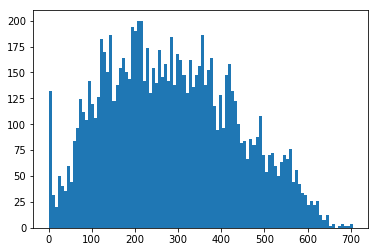

In [86]:
plt.hist(kcc.ravel(),bins=100); plt.show()

In [66]:
yData = np.where(tData[lData>0])
len(yData),tData[(lData>30)].max(),lData.max()

(1, 255, 75)